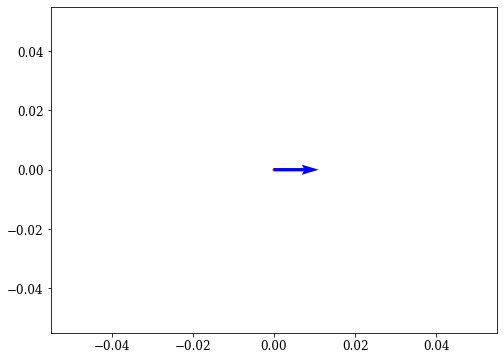

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.figsize"] = (8,6)
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
import time
from mpl_toolkits import mplot3d
#%matplotlib notebook
from matplotlib.animation import FuncAnimation

E = 1e4
A = 0.111

nodes = []
bars = []

    

a = 1
### Nodes
nodes.append([0,0])
nodes.append([a,0])
nodes.append([a/2,np.sqrt(3)/2*a])
### Bars
bars.append([0,1])
bars.append([1,2])
bars.append([2,0])

nodes = np.array(nodes).astype(float)
bars = np.array(bars)

#Apply force
P = np.zeros_like(nodes)
P[2,0] = 10

# support displacement
Ur = [0,0, 0, 0]

DOFCON = np.ones_like(nodes).astype(int)
DOFCON[0,:] = 0
DOFCON[1,:] = 0
    
def rotate(x,y,xo,yo,c,s): #rotate x,y around xo,yo by theta (rad)
    xr=c*(x-xo)-s*(y-yo)   + xo
    yr=s*(x-xo)+c*(y-yo)  + yo
    return xr,yr
    
def plot(nodes, Dnodes, scale = None):
    ne = len(bars)
    fig, axs = plt.subplots(2)
    
    # utils
    d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
    L = np.sqrt((d**2).sum(axis=1))
    angle = d.T/L
    c = angle[0]
    s = angle[1]
    
    # Displacement
    for i in range(ne):
        xi, xj = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yj = nodes[bars[i,0],1], nodes[bars[i,1],1]
        axs[0].plot([xi,xj], [yi, yj], 'b', linewidth = 1)
    for i in range(ne):
        dxi, dxj = Dnodes[bars[i,0],0], Dnodes[bars[i,1],0]
        dyi, dyj = Dnodes[bars[i,0],1], Dnodes[bars[i,1],1]
        axs[0].plot([dxi,dxj], [dyi, dyj], 'r', linewidth = 1)
        
    # T/C 
    for i in range(ne):
        xi, xj = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yj = nodes[bars[i,0],1], nodes[bars[i,1],1]
        axs[1].plot([xi,xj], [yi, yj], 'b', linewidth = 1)
    for i in range(ne):
        xi, xj = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yj = nodes[bars[i,0],1], nodes[bars[i,1],1]
        Nmax = np.max(N)
        t = N[i]/Nmax
        print(i+1,c[i],s[i])
        xri, yri = rotate(xi,t,xi,yi,c[i],s[i])
        xrj, yrj = rotate(xj,t,xj,yj,c[i],s[i])
        axs[1].plot([xi, xri, xrj, xj], [yi, yri, yrj, yj], 'r', linewidth = 2)
        if t > 0 :
            axs[1].fill([xi, xri, xrj, xj], [yi, yri, yrj, yj], 'c', alpha = 0.3)
        else : 
            axs[1].fill([xi, xri, xrj, xj], [yi, yri, yrj, yj], 'y', alpha = 0.3)
        axs[1].text(xi,yi, str(round(t,4)),rotation = 0)
    
    axs[0].set_aspect(1)
    axs[1].set_aspect(1)
    
def truss_analyse(DOF,nodes,bars):
    NN = len(nodes)
    NE = len(bars)
    NDOF = DOF*NN
    d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
    L = np.sqrt((d**2).sum(axis=1))
    angle = d.T/L
    a = np.concatenate((-angle.T,angle.T),axis=1)
    K = np.zeros([NDOF,NDOF])
    for k in range(NE) :
        aux = DOF*bars[k,:]
        index = np.r_[aux[0]:aux[0]+DOF,aux[1]:aux[1]+DOF]
        
        ES = np.dot(a[k][np.newaxis].T*E*A,a[k][np.newaxis]/L[k])
        K[np.ix_(index,index)] = K[np.ix_(index,index)] + ES
        
    #print("distance : \n",d,"\n Longeuur \n",L,"\n angle \n",a,"\n Raideur matrice \n",K,"\n")
    
    freeDOF = DOFCON.flatten().nonzero()[0]
    supportDOF = (DOFCON.flatten() == 0).nonzero()[0]
    #print(supportDOF)
    
    Kff = K[np.ix_(freeDOF,freeDOF)]
    Kfr = K[np.ix_(freeDOF,supportDOF)]
    Krf = Kfr.T
    Krr = K[np.ix_(supportDOF,supportDOF)]
    Pf = P.flatten()[freeDOF]
    Uf = np.linalg.solve(Kff,Pf)
    U = DOFCON.astype(float).flatten()
    U[freeDOF] = Uf
    U[supportDOF] = Ur
    U = U.reshape(NN,DOF)
    u = np.concatenate((U[bars[:,0]],U[bars[:,1]]),axis=1)
    N = E*A/L[:]*(a[:]*u[:]).sum(axis=1)
    R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1)
    R = R.reshape(2*(DOF-1),DOF)
    return np.array(N),np.array(R),U


N, R, U = truss_analyse(2,nodes,bars)
scale = 1
Dnodes = U*scale + nodes
#plot(nodes, Dnodes, scale = None)

def test_rot():
    fig, axs = plt.subplots(1)
    v1 = [0,0]
    v2 = [1,0]
    rotate(*v1,1,0,-0.5,0.86)
    V = np.array([v1, v2])
    origin = np.array([[0, 0],[0, 0]]) # origin point

    axs.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=10)
    
test_rot()

## Sources :
- 2D : https://www.youtube.com/watch?v=Y-ILnLMZYMw
- 3D : https://www.youtube.com/watch?v=9U-j1HxchXE